In [13]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/ratio_logging/agents')

100%|██████████| 192/192 [00:19<00:00, 10.09it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["Walker2d-v2", "Hopper-v2", "HalfCheetah-v2", "Humanoid-v2"]
code_level_opts = {
      "clip": [False, True],
      "kl_penalty": [False, True],
      "ppo_lr_adam": [1e-3, 3e-4, 1e-5],
      "sign_advantages": [False, True],
      "kl_penalty_direction": ["new_to_old", "old_to_new"],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
metadata['clip'] = (metadata['clip_eps'] < 1)
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
constraints = constraints.merge(key_metadata, on='exp_id')
constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

In [6]:
def filter_opts(df, **kwargs):
    for k, v in kwargs.items():
        df = df[df[k] == v]
    return df

# Plot (ratio-1)^2 average

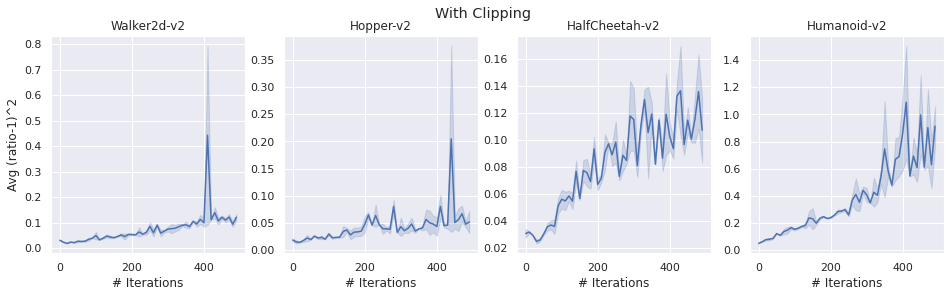

In [28]:
# Plot setup
fig, ax = plt.subplots(1, 4, figsize=(16,4))

for j, g in enumerate(games):
        filt = filter_opts(constraints_heldout, clip=True, kl_penalty=False,
                           game=g, ppo_lr_adam=3e-4, sign_advantages=False)
        sns.lineplot(filt.opt_step, filt.avg_rat_minus_one_sq, n_boot=100,
                     ax=ax.flatten()[j], legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0].set_ylabel('Avg (ratio-1)^2')
for a in ax:
    a.set_xlabel('# Iterations')
    
#handles, labels = ax[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=2)
fig.suptitle('With Clipping')

plt.show()

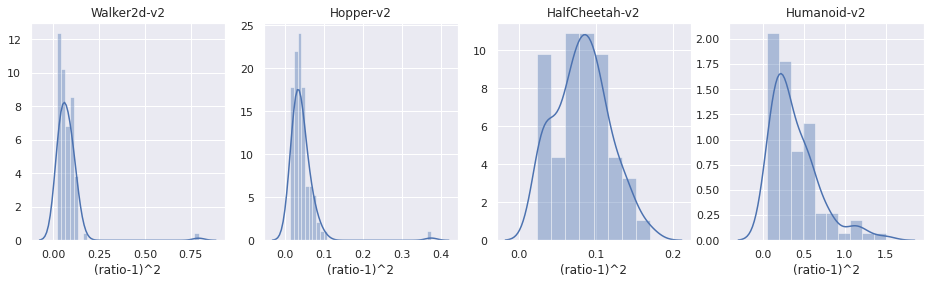

In [43]:
# Plot setup
fig, ax = plt.subplots(1, 4, figsize=(16,4))

for j, g in enumerate(games):
        filt = filter_opts(constraints_heldout, clip=True, kl_penalty=False,
                           game=g, ppo_lr_adam=3e-4, sign_advantages=False)
        #filt = filt[filt.avg_rat_minus_one_sq < 1] # remove outliers
        sns.distplot(filt.avg_rat_minus_one_sq, ax=ax.flatten()[j])
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0].set_xlabel('Density')
for a in ax:
    a.set_xlabel('(ratio-1)^2')
    
#handles, labels = ax[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=2)
#fig.suptitle('With Clipping')

plt.show()

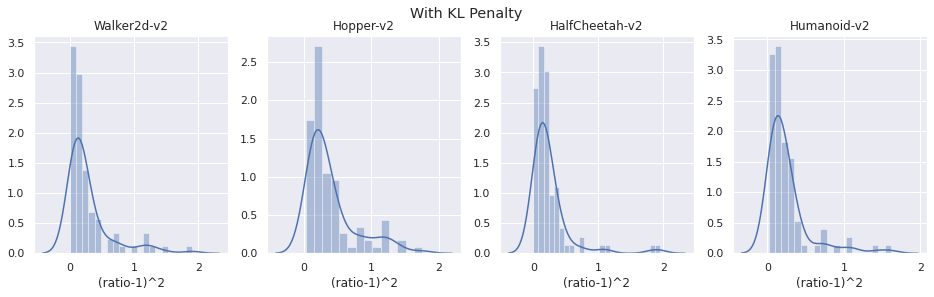

In [36]:
# Plot setup
fig, ax = plt.subplots(1, 4, figsize=(16,4))

for j, g in enumerate(games):
        filt = filter_opts(constraints_heldout, clip=False, kl_penalty=True,
                           game=g, ppo_lr_adam=3e-4, sign_advantages=False)
        filt = filt[filt.avg_rat_minus_one_sq < 2] # remove outliers
        sns.distplot(filt.avg_rat_minus_one_sq, ax=ax.flatten()[j])
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0].set_xlabel('Density')
for a in ax:
    a.set_xlabel('(ratio-1)^2')
    
#handles, labels = ax[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=2)
fig.suptitle('With KL Penalty')

plt.show()

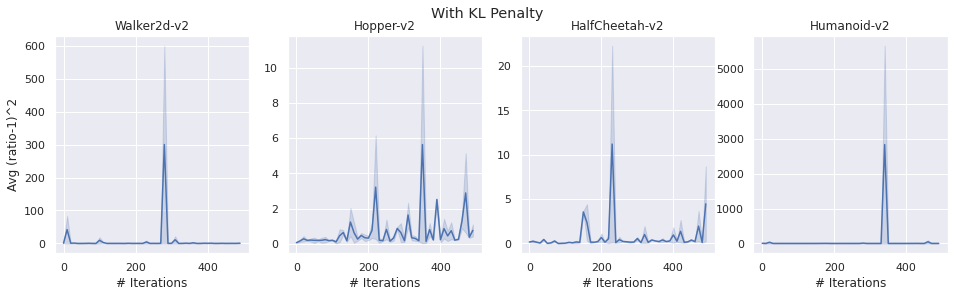

In [29]:
# Plot setup
fig, ax = plt.subplots(1, 4, figsize=(16,4))

for j, g in enumerate(games):
        filt = filter_opts(constraints_heldout, clip=False, kl_penalty=True,
                           game=g, ppo_lr_adam=3e-4, sign_advantages=False)
        sns.lineplot(filt.opt_step, filt.avg_rat_minus_one_sq, n_boot=100,
                     ax=ax.flatten()[j], legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0].set_ylabel('Avg (ratio-1)^2')
for a in ax:
    a.set_xlabel('# Iterations')
    
#handles, labels = ax[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=2)
fig.suptitle('With KL Penalty')

plt.show()

# Plot mean rewards

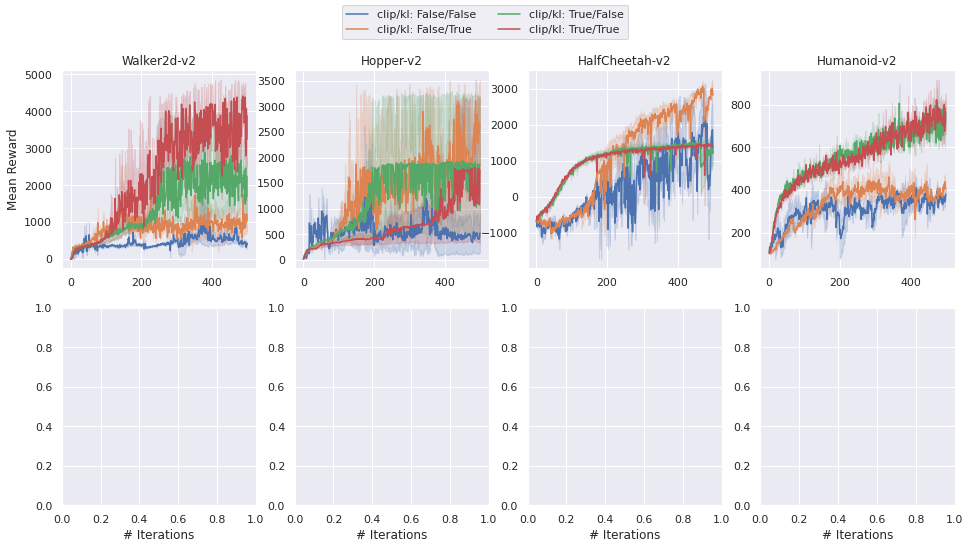

In [45]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for c in code_level_opts['clip']:
        for k in code_level_opts['kl_penalty']:
            filt = filter_opts(opt, clip=c, kl_penalty=k, game=g, ppo_lr_adam=3e-4, sign_advantages=False)
            sns.lineplot(filt.opt_step, filt.mean_reward, n_boot=100,
                         ax=ax.flatten()[j], label=f"clip/kl: {c}/{k}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

plt.show()

In [53]:
filt = filter_opts(constraints_heldout, ppo_lr_adam=3e-4, sign_advantages=False, clip=True, kl_penalty=False)

In [54]:
filt.head()

,avg_kl_old_to_new,avg_kl_new_to_old,avg_ratio,avg_rat_minus_one_sq,max_ratio,opt_step,exp_id,game,clip,kl_penalty,ppo_lr_adam,sign_advantages
50,0.014286,0.014123,1.002568,0.029965,2.080559,0,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
51,0.011570,0.011520,0.997578,0.024201,2.057647,10,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
52,0.009998,0.009852,0.999511,0.019199,1.917814,20,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
53,0.012904,0.012677,1.001194,0.025534,1.879576,30,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
54,0.011257,0.011084,0.999569,0.022190,1.837460,40,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False


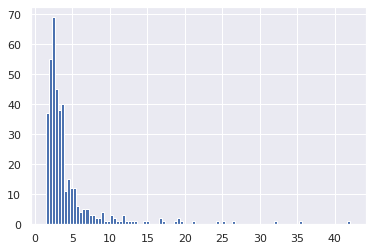

In [57]:
plt.hist(filt.max_ratio, bins=100)
plt.show()

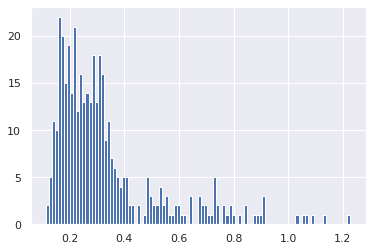

In [59]:
plt.hist(np.sqrt(filt.avg_rat_minus_one_sq), bins=100)
plt.show()

In [81]:
filt = filter_opts(constraints_heldout, ppo_lr_adam=3e-4, sign_advantages=False,
                   clip=False, kl_penalty=True, kl_penalty_direction='old_to_new')

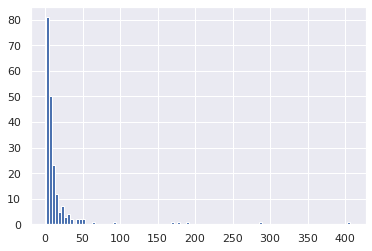

In [82]:
plt.hist(filt.max_ratio, bins=100)
plt.show()

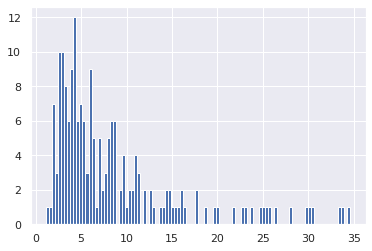

In [83]:
plt.hist(filt[filt.max_ratio < 40].max_ratio, bins=100)
plt.show()

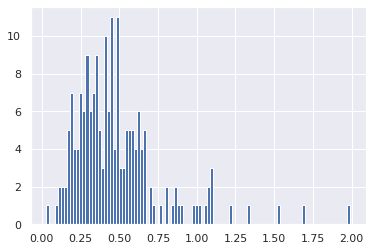

In [84]:
plt.hist(np.sqrt(filt[filt.max_ratio < 40].avg_rat_minus_one_sq), bins=100)
plt.show()

In [14]:
filt = filter_opts(constraints_heldout, ppo_lr_adam=3e-4, sign_advantages=False,
                   clip=False, kl_penalty=True, kl_penalty_direction='new_to_old')

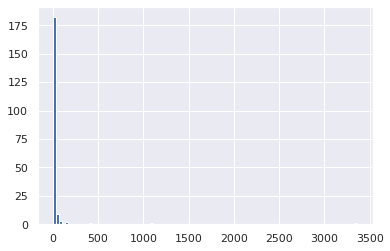

In [76]:
plt.hist(filt.max_ratio, bins=100)
plt.show()

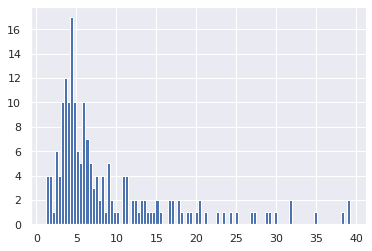

In [77]:
plt.hist(filt[filt.max_ratio < 40].max_ratio, bins=100)
plt.show()

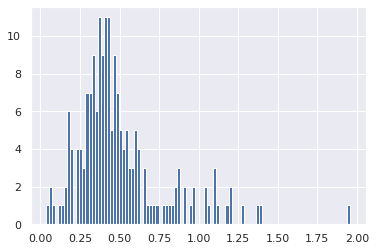

In [78]:
plt.hist(np.sqrt(filt[filt.max_ratio < 40].avg_rat_minus_one_sq), bins=100)
plt.show()

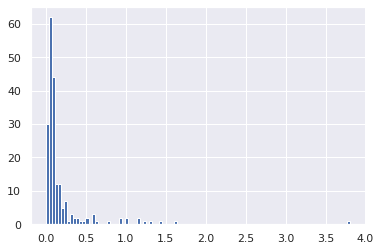

In [18]:
plt.hist(filt.avg_kl_new_to_old, bins=100)
plt.show()

In [20]:
np.mean(filt.avg_kl_new_to_old), np.median(filt.avg_kl_new_to_old)

(0.19133839916088619, 0.08352550491690636)

## Plot Mean Std

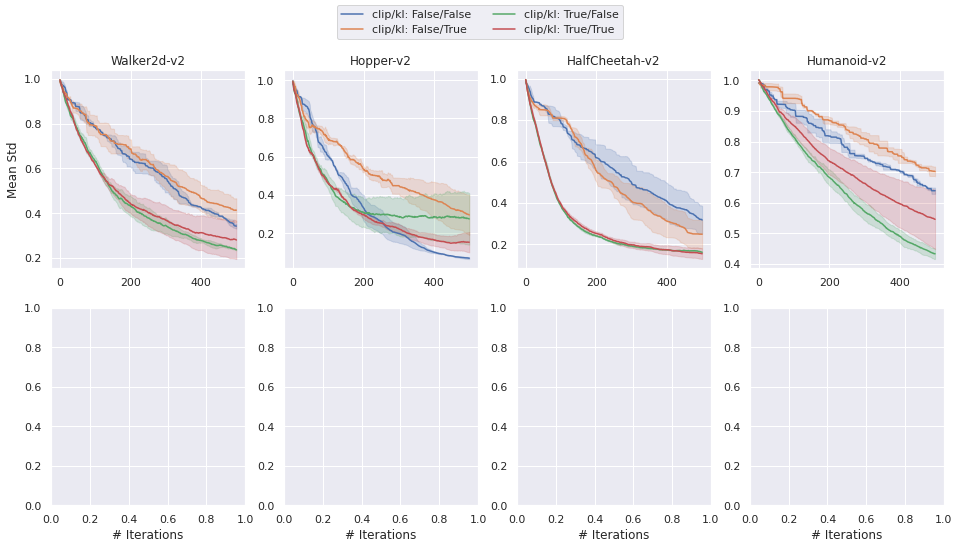

In [7]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for c in code_level_opts['clip']:
        for k in code_level_opts['kl_penalty']:
            filt = filter_opts(opt, clip=c, kl_penalty=k, game=g, ppo_lr_adam=3e-4, sign_advantages=False)
            sns.lineplot(filt.opt_step, filt.mean_std, n_boot=100,
                         ax=ax.flatten()[j], label=f"clip/kl: {c}/{k}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Std')
ax[1][0].set_xlabel('Mean Std')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

plt.show()

# Reward Scaling Effects

In [24]:
import pandas as pd
rewards = pd.read_csv('../src/reward_debug/rewards.csv', names=['t_in_traj', 'reward_raw', 'reward_scaled']).iloc[1:]

In [25]:
rewards

,t_in_traj,reward_raw,reward_scaled
1,2.0,0.868082,1.432036
2,3.0,0.729613,0.929555
3,4.0,0.375061,0.442770
4,5.0,-0.156949,-0.199150
5,6.0,-0.517961,-0.734690
...,...,...,...
1099055,140.0,3.715255,0.033174
1099056,141.0,3.763812,0.033607
1099057,142.0,3.713344,0.033157
1099058,143.0,3.680263,0.032861


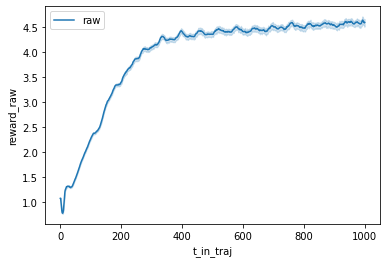

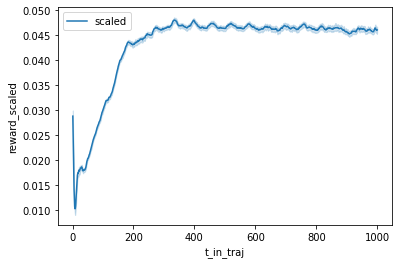

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=rewards, x='t_in_traj', y='reward_raw', n_boot=100, label='raw')
plt.show()
sns.lineplot(data=rewards, x='t_in_traj', y='reward_scaled', n_boot=100, label='scaled')
plt.show()

(array([2.0000e+00, 1.0000e+00, 5.0000e+00, 8.0000e+00, 1.0000e+01,
        1.9000e+01, 2.4000e+01, 3.0000e+01, 3.5000e+01, 6.5000e+01,
        6.8000e+01, 8.6000e+01, 1.6100e+02, 1.8100e+02, 2.4300e+02,
        3.0000e+02, 3.7200e+02, 4.4600e+02, 5.2100e+02, 5.8300e+02,
        6.9200e+02, 7.8200e+02, 8.9900e+02, 1.0270e+03, 1.1670e+03,
        1.1520e+03, 1.3120e+03, 1.3230e+03, 1.5360e+03, 1.6980e+03,
        1.9540e+03, 2.1770e+03, 2.6250e+03, 3.3600e+03, 4.8020e+03,
        8.4530e+03, 1.4376e+04, 1.7814e+04, 2.0485e+04, 2.0348e+04,
        1.9681e+04, 1.9846e+04, 2.1535e+04, 2.3025e+04, 2.0291e+04,
        1.6282e+04, 1.5071e+04, 1.5686e+04, 1.7118e+04, 2.0225e+04,
        2.3351e+04, 2.5521e+04, 2.6299e+04, 2.5545e+04, 2.4507e+04,
        2.2668e+04, 2.1180e+04, 1.9350e+04, 1.8563e+04, 1.7863e+04,
        1.7586e+04, 1.7586e+04, 1.8138e+04, 1.8773e+04, 2.0093e+04,
        2.1618e+04, 2.3292e+04, 2.5869e+04, 2.7182e+04, 2.9184e+04,
        3.1680e+04, 3.3603e+04, 3.5302e+04, 3.59

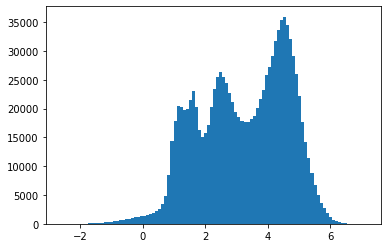

In [61]:
plt.hist(rewards.reward_raw, bins=100)

(array([9.3300e+02, 4.2000e+01, 3.8000e+01, 4.6000e+01, 5.2000e+01,
        4.6000e+01, 5.4000e+01, 5.0000e+01, 5.9000e+01, 6.4000e+01,
        6.3000e+01, 6.7000e+01, 5.8000e+01, 6.4000e+01, 8.0000e+01,
        7.9000e+01, 9.4000e+01, 8.7000e+01, 9.8000e+01, 9.5000e+01,
        8.2000e+01, 1.0400e+02, 1.1200e+02, 1.2300e+02, 1.2100e+02,
        1.3300e+02, 1.2500e+02, 1.4500e+02, 1.4900e+02, 1.6400e+02,
        1.5200e+02, 2.0000e+02, 1.8700e+02, 1.8600e+02, 2.0800e+02,
        1.8700e+02, 2.1500e+02, 2.5100e+02, 2.4100e+02, 2.9400e+02,
        2.7500e+02, 3.2600e+02, 3.5900e+02, 3.5400e+02, 4.1300e+02,
        4.2700e+02, 4.6100e+02, 5.2400e+02, 5.9600e+02, 6.7100e+02,
        6.6700e+02, 8.7700e+02, 1.1450e+03, 2.1390e+03, 6.4880e+03,
        8.7010e+03, 1.5048e+04, 2.7521e+04, 3.1994e+04, 3.4659e+04,
        3.6116e+04, 3.5087e+04, 3.3241e+04, 2.8466e+04, 2.6002e+04,
        2.8108e+04, 3.4628e+04, 4.3241e+04, 5.1996e+04, 6.4109e+04,
        8.3350e+04, 9.0785e+04, 8.6901e+04, 7.74

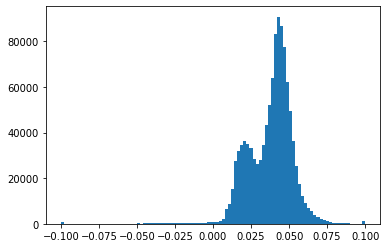

In [60]:
plt.hist(np.clip(rewards.reward_scaled,-0.1,.1), bins=100)

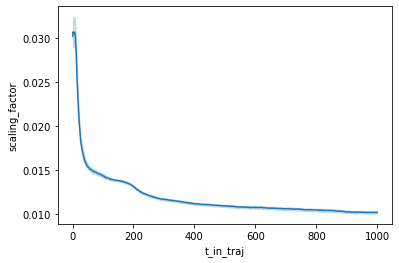

In [32]:
rewards['scaling_factor'] = rewards['reward_scaled'] / rewards['reward_raw']
sns.lineplot(data=rewards, x='t_in_traj', y='scaling_factor', n_boot=100)
plt.show()

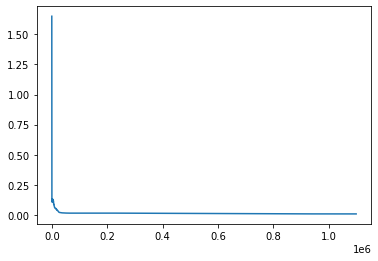

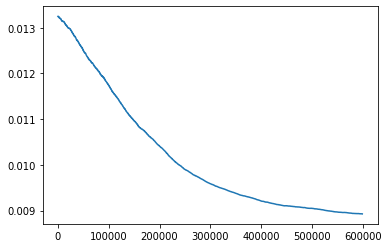

In [54]:
import numpy as np
plt.plot(rewards['scaling_factor'].values)
plt.show()
plt.plot(rewards['scaling_factor'].values[500000:])
plt.show()

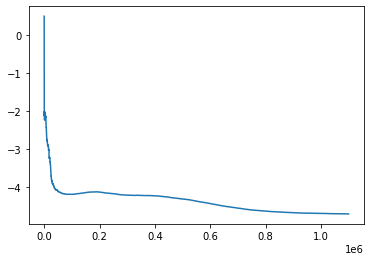

In [46]:
plt.plot(np.arange(len(rewards)), np.log(rewards['scaling_factor'].values))
plt.show()

In [47]:
rewards

,t_in_traj,reward_raw,reward_scaled,scaling_factor
1,2.0,0.868082,1.432036,1.649655
2,3.0,0.729613,0.929555,1.274038
3,4.0,0.375061,0.442770,1.180529
4,5.0,-0.156949,-0.199150,1.268883
5,6.0,-0.517961,-0.734690,1.418428
...,...,...,...,...
1099055,140.0,3.715255,0.033174,0.008929
1099056,141.0,3.763812,0.033607,0.008929
1099057,142.0,3.713344,0.033157,0.008929
1099058,143.0,3.680263,0.032861,0.008929


In [3]:
r = readers.CollectionReader('../src/debug/agents')

100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


In [4]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
nadv = r.df('normalized_advantage')
nadv['opt_step'] = (nadv.index % 50) * 10
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

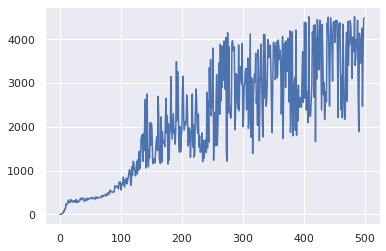

In [6]:
plt.plot(opt.mean_reward)

In [9]:
nadv.head()

,mean_pre_norm,std_pre_norm,opt_step,skewness,kurtosis,max,min,exp_id
0,-0.108236,0.734888,0,-1.310363,9.056240,3.432833,-6.011443,3cab361b-c062-48e7-a1f6-25e8ebc79f92
1,0.203039,0.403627,10,-0.515846,3.632357,3.217671,-4.269290,3cab361b-c062-48e7-a1f6-25e8ebc79f92
2,0.017700,0.215406,20,-0.541456,6.903051,4.499092,-4.923760,3cab361b-c062-48e7-a1f6-25e8ebc79f92
3,-0.009492,0.187655,30,-0.198980,6.229520,6.322942,-3.496149,3cab361b-c062-48e7-a1f6-25e8ebc79f92
4,-0.031848,0.181756,40,-0.452555,4.518456,4.655423,-4.645192,3cab361b-c062-48e7-a1f6-25e8ebc79f92


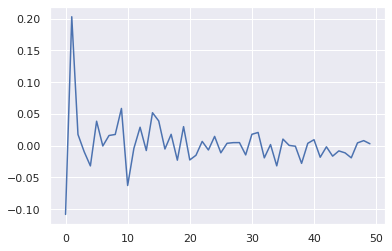

In [10]:
plt.plot(nadv.mean_pre_norm)

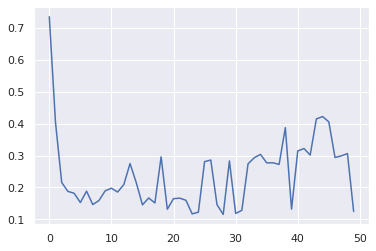

In [11]:
plt.plot(nadv.std_pre_norm)